In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import animation
import torch.nn as nn
import torch.nn.functional as F
import os
import wandb
import cProfile
import pstats

from FNO import FNOModel
from UNet import UNet3D
from utils import *

%cd
pathToFolder = r'Documents\2024-II\AutoregressiveNeuralOperators'
%cd $pathToFolder

C:\Users\tphar
C:\Users\tphar\Documents\2024-II\AutoregressiveNeuralOperators


# To do
- Investigate OG dataset
- Create FeNics Env Snellius
- Use SIMM loss instead of MSE?


# Done
- Make NS dataset
- Make FNO
- Make model autoregressive
- Rollout -> only loss at final step
- Make Simple U-Net
- Setup WandB
- Get snellius credits
- Setup small repo
- Test num_workers= and pin_memory=
- Create gifmaker
- Get OG dataset

In [2]:
pathToData = r'data\t1-t50VorticityZ-32x32-v1e-3-T50-N40.npy'
data = np.load(pathToData)
data.shape

(40, 32, 32, 50)

In [3]:
tensorFormat = torch.tensor(data, dtype=torch.float32)
distribution=[0.8, 0.15, 0.05]
timeDistribution=[0.2, 0.8]

nSamples = len(tensorFormat)
bigT = 10
tensorFormatX, tensorFormatY = (
    tensorFormat[..., :bigT],
    tensorFormat[..., bigT:],
)
print(tensorFormatX.shape, tensorFormatY.shape)
print(tensorFormat.shape[-1]-bigT)

torch.Size([40, 32, 32, 10]) torch.Size([40, 32, 32, 40])
40


In [12]:
trainingIdx, validationIdx, _ = [int(nSamples * k) for k in distribution]
trainingX, validationX, testX = (
    tensorFormatX[:trainingIdx, ...],
    tensorFormatX[trainingIdx : trainingIdx + validationIdx, ...],
    tensorFormatX[trainingIdx + validationIdx :, ...],
)

trainingY, validationY, testY = (
    tensorFormatY[:trainingIdx, ...],
    tensorFormatY[trainingIdx : trainingIdx + validationIdx, ...],
    tensorFormatY[trainingIdx + validationIdx :, ...],
)
print(trainingX.shape, validationX.shape, testX.shape)
print(trainingY.shape, validationY.shape, testY.shape)

fullValidationData = tensorFormat[trainingIdx : trainingIdx + validationIdx, ...]

torch.Size([32, 32, 32, 10]) torch.Size([6, 32, 32, 10]) torch.Size([2, 32, 32, 10])
torch.Size([32, 32, 32, 40]) torch.Size([6, 32, 32, 40]) torch.Size([2, 32, 32, 40])


In [13]:
#trainingX = trainingX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
training = TensorDataset(trainingX, trainingY)
print(trainingX.shape, trainingY.shape)

#validationX = validationX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
validation = TensorDataset(validationX, validationY)

#testX = testX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
test = TensorDataset(testX, testY)

torch.Size([32, 32, 32, 10]) torch.Size([32, 32, 32, 40])


In [14]:
gpuForLoader = [False, True]
workers = [1,1,2,4,8,12]
#numworkersTest(training, workers, 8)

In [15]:
batchSize = 8
shuffleTraining = True
trainingDataLoader = DataLoader(
    training, batch_size=batchSize, shuffle=shuffleTraining, num_workers=1, pin_memory=True#2
)

validationDataLoader = DataLoader(
    validation, batch_size=batchSize, shuffle=False, num_workers=1, pin_memory=True
)

testDataLoader = DataLoader(
    test, batch_size=batchSize, shuffle=False, num_workers=1, pin_memory=True)

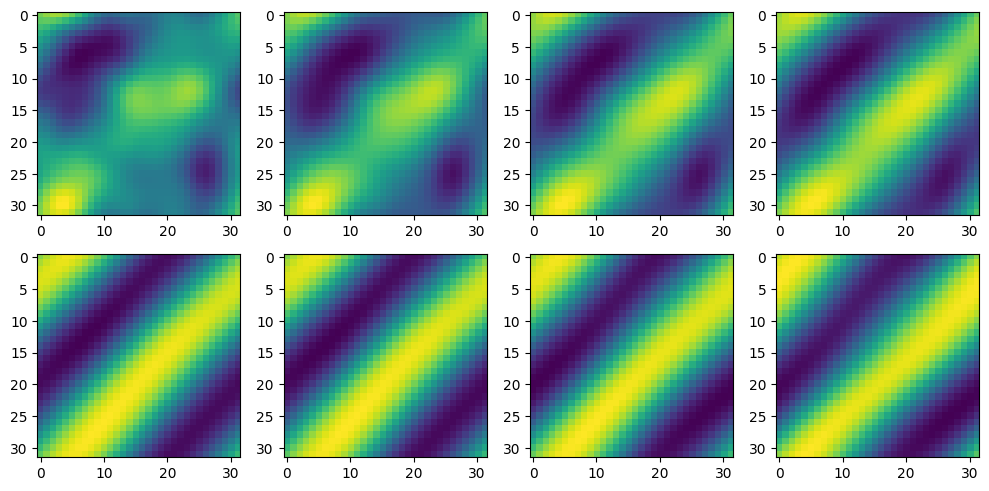

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax[0,0].imshow(trainingX[0, :, :, 0], cmap='viridis')
ax[0,1].imshow(trainingX[0, :, :, 1], cmap='viridis')
ax[0,2].imshow(trainingX[0, :, :, 2], cmap='viridis')
ax[0,3].imshow(trainingX[0, :, :, 3], cmap='viridis')
ax[1,0].imshow(trainingY[0, :, :, 0], cmap='viridis')
ax[1,1].imshow(trainingY[0, :, :, 1], cmap='viridis')
ax[1,2].imshow(trainingY[0, :, :, 5], cmap='viridis')
ax[1,3].imshow(trainingY[0, :, :, 9], cmap='viridis')
plt.tight_layout()
plt.show()

In [21]:
modeltype = 'UNet'
model = UNet3D(in_neurons=1, out_neurons=1)
x = torch.randn(4, 32, 32, 10) 
x.unsqueeze_(1) # add dimension for the channels
output = model(x)
print(f"Input shape: {x.shape}, Output shape: {output.shape}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.optimizer = torch.optim.Adam(model.parameters())


Input shape: torch.Size([4, 1, 32, 32, 10]), Output shape: torch.Size([4, 32, 32, 10])


In [24]:
epochs = 5

wandb.init(project="testUNet", config={
    "epochs": epochs,
    "loss_function": model.loss_function, 
})

max_unrolling_steps = 4


for epoch in range(epochs):
    model.train()
    train_loss_temp = 0
    for batch_idx, (x, y) in enumerate(trainingDataLoader):
        
        for unrolling_steps in range(0, max_unrolling_steps):
            xt, yt = x.to(device), y.to(device)
            with torch.no_grad():
                for tstep in range(1, unrolling_steps+1):
                    xt.unsqueeze_(1)
                    y_hat = model(xt)
                    xt = y_hat
            model.optimizer.zero_grad()
            xt.unsqueeze_(1)
            y_hat = model(xt)
            
            train_loss = model.loss_function(y_hat, yt[:,:,:,unrolling_steps*10 : (unrolling_steps+1)*10])
            train_loss.backward()
            model.optimizer.step()
            train_loss_temp += train_loss.item()  # Accumulate loss for the epoch
        avg_train_loss = train_loss_temp / len(trainingDataLoader) / max_unrolling_steps
    
    model.eval()
    val_loss_temp = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(validationDataLoader):
            xt, yt = x.to(device), y.to(device)
            for tstep in range(0, 4):
                xt.unsqueeze_(1)
                y_hat = model(xt)
                xt = y_hat
            val_loss = model.loss_function(y_hat, yt[:,:,:,30:])
            val_loss_temp += val_loss.item()
        avg_val_loss = val_loss_temp / len(validationDataLoader)
        
    wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
        })
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")
wandb.finish()

Epoch 1/5 - Train Loss: 0.0705 - Val Loss: 0.1722
Epoch 2/5 - Train Loss: 0.0627 - Val Loss: 0.2195
Epoch 3/5 - Train Loss: 0.0660 - Val Loss: 0.1427
Epoch 4/5 - Train Loss: 0.0529 - Val Loss: 0.0947
Epoch 5/5 - Train Loss: 0.0476 - Val Loss: 0.0889


epoch,▁▃▅▆█
train_loss,█▆▇▃▁
val_loss,▅█▄▁▁
epoch,5
train_loss,0.04756
val_loss,0.08893


In [ ]:
#torch.save(model.state_dict(), "models/NS_UNetmodel_v3.pth")

In [25]:
model.load_state_dict(torch.load("models/NS_UNetmodel_v3.pth"))

C:\Users\tphar\AppData\Local\Temp\ipykernel_2324\473630253.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/NS_UNetmodel_v3.pth")

FileNotFoundError: [Errno 2] No such file or directory: 'models/NS_UNetmodel_v3.pth'

In [36]:
# rollout code for the FNO model
if modeltype == 'FNO':
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(validationDataLoader):
            x, y = x.to(device), y.to(device)
            out = x.clone()
            for tstep in range(1, 5):
                x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                meshgrid = get_meshgrid(x.shape, tstep).to(torch.device('cuda'))
                x = torch.concat((x, meshgrid), dim=-1) # [B, X, Y, T, 3 + T_in]
                y_hat = model(x)
                x = y_hat
                out = torch.cat((out, x.clone()), dim=-1)
            #tstep = 4
            #x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
            #meshgrid = get_meshgrid(x.shape, tstep).to(torch.device('cuda'))
            #x = torch.concat((x, meshgrid), dim=-1) # [B, X, Y, T, 3 + T_in]
            #y_hat = model(x)
            break
            
elif modeltype == 'UNet':
    # rollout code for the UNet model
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(validationDataLoader):
            x, y = x.to(device), y.to(device)
            out = x.clone()
            y_tot = x.clone()
            y_tot = torch.cat((y_tot, y), dim=-1)
            for tstep in range(1, 5):
                
                x.unsqueeze_(1)
                y_hat = model(x)
                x = y_hat
                out = torch.cat((out, x.clone()), dim=-1) 
            break
else:
    print('Model type not recognized')
out.shape, y.shape, y_hat.shape

(torch.Size([6, 32, 32, 50]),
 torch.Size([6, 32, 32, 40]),
 torch.Size([6, 32, 32, 10]))

C:\Users\tphar\AppData\Local\Temp\ipykernel_2324\3601058047.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


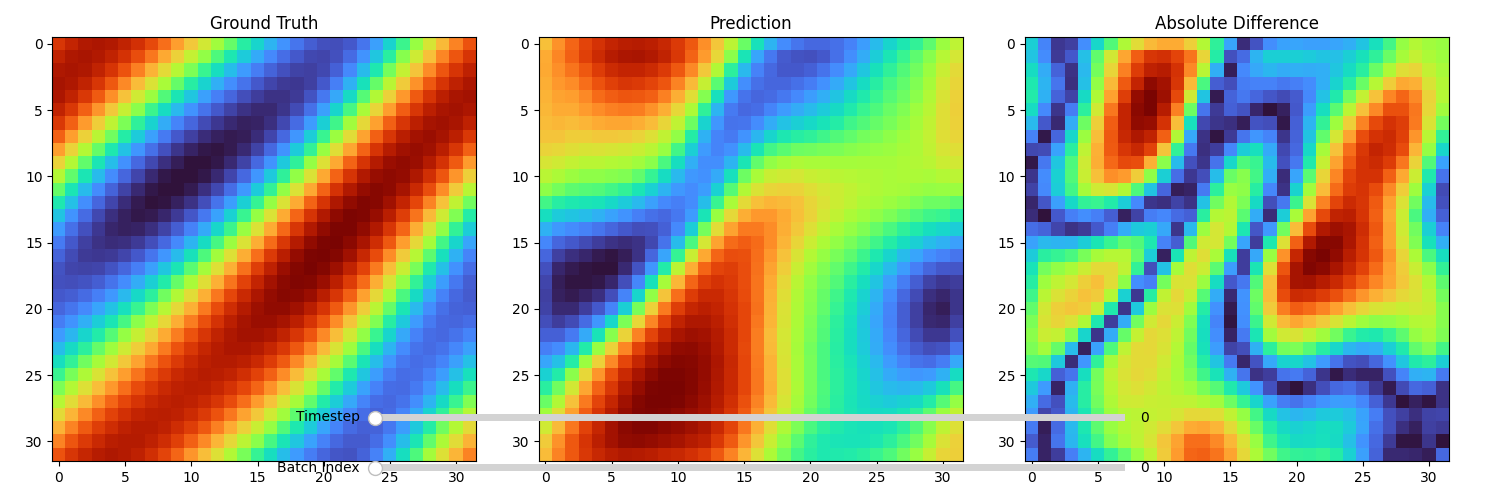

IndexError: index 10 is out of bounds for dimension 3 with size 10

IndexError: index 11 is out of bounds for dimension 3 with size 10

IndexError: index 12 is out of bounds for dimension 3 with size 10

IndexError: index 13 is out of bounds for dimension 3 with size 10

IndexError: index 14 is out of bounds for dimension 3 with size 10

IndexError: index 15 is out of bounds for dimension 3 with size 10

IndexError: index 16 is out of bounds for dimension 3 with size 10

IndexError: index 17 is out of bounds for dimension 3 with size 10

IndexError: index 18 is out of bounds for dimension 3 with size 10

IndexError: index 19 is out of bounds for dimension 3 with size 10

IndexError: index 20 is out of bounds for dimension 3 with size 10

IndexError: index 21 is out of bounds for dimension 3 with size 10

IndexError: index 22 is out of bounds for dimension 3 with size 10

IndexError: index 23 is out of bounds for dimension 3 with size 10

In [ ]:
%matplotlib widget


ts = 0
batch_idx = 0

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplots_adjust(bottom=0.3)  
colormap = 'turbo'
im0 = ax[0].imshow(y[batch_idx, :, :, ts].cpu(), cmap=colormap)
im1 = ax[1].imshow(out[batch_idx, :, :, ts].cpu().detach(), cmap=colormap)
im2 = ax[2].imshow(abs(y[batch_idx, :, :, ts].cpu() - out[batch_idx, :, :, ts].cpu().detach()), cmap=colormap)

ax[0].set_title("Ground Truth")
ax[1].set_title("Prediction")
ax[2].set_title("Absolute Difference")

ax_slider_ts = plt.axes([0.25, 0.15, 0.5, 0.03]) 
slider_ts = Slider(ax_slider_ts, 'Timestep', 0, 39, valinit=ts, valstep=1)

ax_slider_batch = plt.axes([0.25, 0.05, 0.5, 0.03])  
slider_batch = Slider(ax_slider_batch, 'Batch Index', 0, y.shape[0] - 1, valinit=batch_idx, valstep=1)

def update(val):
    ts = int(slider_ts.val)
    batch_idx = int(slider_batch.val) 
    im0.set_data(y[batch_idx, :, :, ts].cpu())
    im1.set_data(out[batch_idx, :, :, ts].cpu().detach())
    im2.set_data(abs(y[batch_idx, :, :, ts].cpu() - out[batch_idx, :, :, ts].cpu().detach()))
    fig.canvas.draw_idle()

slider_ts.on_changed(update)
slider_batch.on_changed(update)
plt.tight_layout()
plt.show()



In [28]:
def createGif(data, filename, colormap='viridis'):
    fig = plt.figure(figsize=(5,5))    
    cmin= torch.min(data)
    cmax = torch.max(data)
    im = plt.imshow(data[:, :, 0], 
                    animated=True,
                    cmap=colormap,  
                    vmin=cmin, 
                    vmax=cmax)

    plt.tight_layout()
    plt.axis('off')

    def init():
        im.set_data(data[:, :, 0])
        return im,

    def animate(i):
        im.set_array(data[:, :, i])
        return im,

    anim = animation.FuncAnimation(fig,
                                    animate,
                                    init_func=init,
                                    frames=np.shape(data)[2], 
                                    interval=100, 
                                    blit=True)
    outputFolder = 'output/'
    anim.save(outputFolder + filename + ".gif")  
    plt.close(fig)
for batchNumber in range(out.shape[0]):
    createGif(out[batchNumber,:,:,:].cpu(), modeltype + str(batchNumber), 'turbo')
for batchNumber in range(out.shape[0]):
    createGif(fullValidationData[batchNumber,:,:,:], "GroundTruth" + str(batchNumber), 'turbo')


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [57]:
# code from chatGPT

from PIL import Image, ImageSequence, ImageDraw, ImageFont

def combine_gifs_with_titles(gif_paths, titles, output_path):
    gifs = [Image.open(gif) for gif in gif_paths]

    # Check if all GIFs have the same number of frames
    frame_counts = [len(list(ImageSequence.Iterator(gif))) for gif in gifs]
    if len(set(frame_counts)) > 1:
        raise ValueError("All GIFs must have the same number of frames.")

    # Get dimensions for combining
    widths, heights = zip(*(gif.size for gif in gifs))
    total_width = sum(widths)
    max_height = max(heights)
    title_height = 30  # Height for the title bar

    combined_frames = []

    # Font setup (default font)
    try:
        font = ImageFont.truetype("arialbd.ttf", 25)  # Use a system font
    except IOError:
        font = ImageFont.load_default()  # Fallback if the font isn't available

    for frames in zip(*(ImageSequence.Iterator(gif) for gif in gifs)):
        # Create a new blank image for the combined frame
        combined_frame = Image.new("RGBA", (total_width, max_height + title_height), (255, 255, 255, 255))

        # Draw titles
        draw = ImageDraw.Draw(combined_frame)
        x_offset = 0
        for title, width in zip(titles, widths):
            # Calculate text dimensions using textbbox
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            text_x = x_offset + (width - text_width) // 2
            draw.text((text_x, (title_height - text_height) // 2), title, fill="black", font=font)
            x_offset += width

        # Paste each frame below the title bar
        x_offset = 0
        for frame in frames:
            combined_frame.paste(frame, (x_offset, title_height))
            x_offset += frame.width

        combined_frames.append(combined_frame)

    # Save the combined GIF
    combined_frames[0].save(
        output_path,
        save_all=True,
        append_images=combined_frames[1:],
        loop=0,
        duration=gifs[0].info['duration']  # Use the frame duration of the first GIF
    )

# Paths to your GIF files and corresponding titles
for gifext in range(out.shape[0]):
    fileEnd = str(gifext) + ".gif"
    gif_paths = [
        r"output\FNO" + fileEnd,
        r"output\GroundTruth" + fileEnd,
        r"output\UNet" + fileEnd
    ]
    titles = ["FNO", "Ground Truth", "U-Net"]
    output_path = r"output\FNO+GT+UNet_" + str(gifext) + ".gif"
    combine_gifs_with_titles(gif_paths, titles, output_path)
